# Chapter 4: Long/Short Methodologies: Absolute and Relative

This chapter introduces the relative series methodology
1. Import libraries
2. Bullish/Bearish stocks in the S&P500 in absolute & relative series
3. Relative function
4. Examples of absolute and relative series

### Import Libraries

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Chapter 4: Long/Short Methodologies: Absolute and Relative

import pandas as pd
import numpy as np
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt

### S&P500 stocks making 1 year high (bullish)/ low (bearish) in absolute/relative series
The following chart shows the S&P 500 index and a count of all the constituents in either the bull or bear regime using the absolute price series.

Indices such as S&P 500, Nasdaq 100, FTSE 100, and Topix are the market capitalization weighted average of their constituents. Roughly half the stocks will do better and the rest worse than the index over any timeframe. 

[batch 1] 0:20 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 2] 20:40 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 3] 40:60 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 4] 60:80 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 5] 80:100 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 6] 100:120 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 7] 120:140 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 8] 140:160 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 9] 160:180 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 10] 180:200 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 11] 200:220 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 12] 220:240 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 13] 240:260 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 14] 260:280 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 15] 280:300 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 16] 300:320 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 17] 320:340 (20 tickers)


[*********************100%***********************]  20 of 20 completed
[                       0%                       ]

[batch 18] 340:360 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 19] 360:380 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 20] 380:400 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 21] 400:420 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 22] 420:440 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 23] 440:460 (20 tickers)


[*********************100%***********************]  20 of 20 completed
[                       0%                       ]

[batch 24] 460:480 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 25] 480:500 (20 tickers)


[*********************100%***********************]  20 of 20 completed


[batch 26] 500:520 (4 tickers)


[*********************100%***********************]  4 of 4 completed


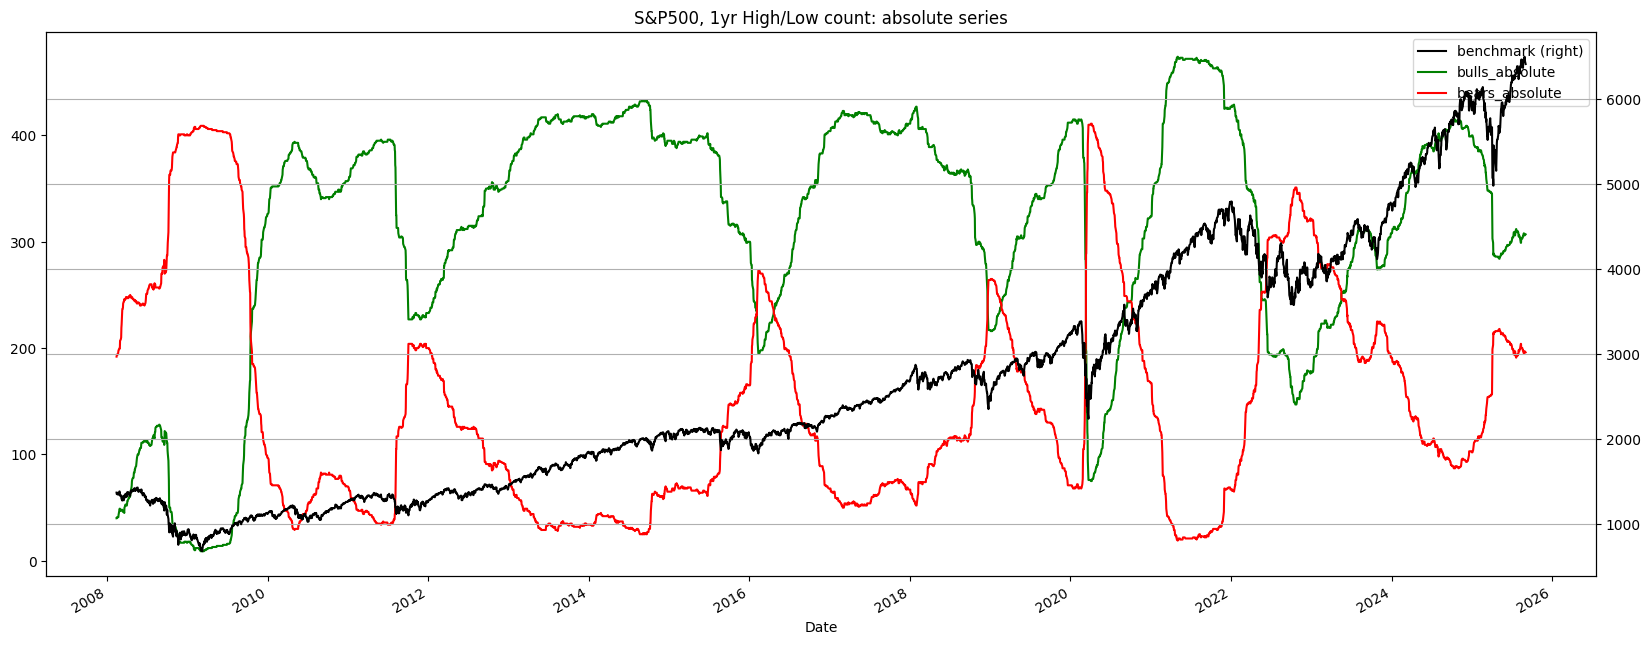

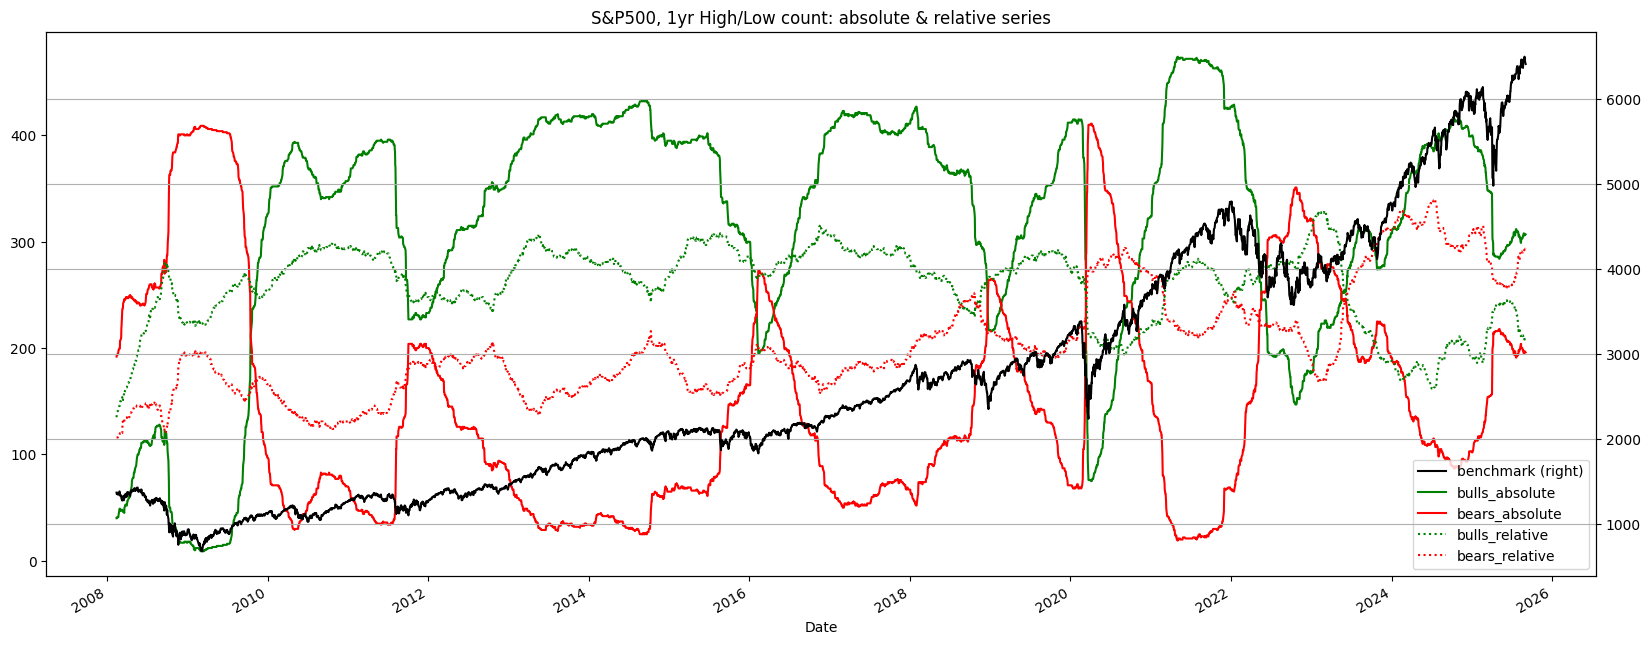

In [3]:
# --- Chapter 4: Long/Short Methodologies: Absolute and Relative (versión robusta) ---

import time, warnings
import numpy as np
import pandas as pd
import requests
import yfinance as yf
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# 1) Sesión con User-Agent y reintentos (mejora estabilidad Wikipedia + yfinance)
from urllib3.util import Retry
from requests.adapters import HTTPAdapter

session = requests.Session()
retries = Retry(
    total=5, connect=5, read=5,
    backoff_factor=1.5,
    status_forcelist=[429, 500, 502, 503, 504],
    allowed_methods=["GET"]
)
session.headers.update({"User-Agent": "Mozilla/5.0 (yfinance-safe)"})
session.mount("https://", HTTPAdapter(max_retries=retries))
yf.session = session  # yfinance usará esta sesión

# 2) Lista S&P500 desde Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp_df = pd.read_html(
    url,
    match="Symbol",
    storage_options={"User-Agent": session.headers["User-Agent"]}
)[0]

# corrige símbolos con punto
sp_df["Symbol"] = sp_df["Symbol"].str.replace(".", "-", regex=False)

bm_ticker = "^GSPC"
tickers_list = [bm_ticker] + sp_df["Symbol"].tolist()

# 3) Descarga en batches
start_date = "2007-01-01"
batch_size = 20
loop_size = int(len(tickers_list) // batch_size) + 2

df_abs = pd.DataFrame()

for t in range(1, loop_size):
    m = (t - 1) * batch_size
    n = t * batch_size
    batch = tickers_list[m:n]
    if not batch:
        continue
    print(f"[batch {t}] {m}:{n} ({len(batch)} tickers)")

    # group_by='column' + ['Close'] → matriz de cierres por ticker
    data = yf.download(
        tickers=batch,
        start=start_date,
        interval="1d",
        group_by="column",
        auto_adjust=True,
        prepost=False,
        threads=True
    )

    # En algunos casos yfinance devuelve Serie si es 1 ticker; homogenizamos
    if isinstance(data, pd.Series):
        data = data.to_frame().T

    # Extraemos cierres como DataFrame (columns = tickers)
    try:
        closes = data["Close"].copy()
    except Exception:
        # Si vino con MultiIndex raro, intentamos rearmar
        if isinstance(data.columns, pd.MultiIndex):
            closes = data.xs("Close", axis=1, level=0)
        else:
            raise

    df_abs = closes if df_abs.empty else df_abs.join(closes, how="outer")

# Ordena columnas (por prolijidad) y asegura benchmark presente
df_abs = df_abs.sort_index()
assert bm_ticker in df_abs.columns, f"No llegó la columna {bm_ticker}"

# 4) Series RELATIVAS: rebase por nivel inicial del benchmark
bm = df_abs[bm_ticker].copy()
first_valid = bm.first_valid_index()
bm0 = bm.loc[first_valid]

df_rel_lvl = df_abs.divide(bm, axis=0).mul(bm0)

# 5) Señales High/Low (ventana ~1 año bursátil)
window = 252

def hi_low_signals(df):
    hi = df.rolling(window).max()
    lo = df.rolling(window).min()
    sig = pd.DataFrame(
        np.where(df.ge(hi), 1, np.where(df.le(lo), -1, np.nan)),
        index=df.index, columns=df.columns
    )
    return sig.ffill()

sig_abs = hi_low_signals(df_abs)
sig_rel = hi_low_signals(df_rel_lvl)

# 6) Conteos de toros/osos
bullbear = pd.DataFrame(index=df_abs.index)
bullbear["benchmark"] = bm.round(2)

bullbear["bulls_absolute"] = (sig_abs > 0).sum(axis=1)
bullbear["bears_absolute"] = (sig_abs < 0).sum(axis=1)
bullbear["bulls_relative"] = (sig_rel > 0).sum(axis=1)
bullbear["bears_relative"] = (sig_rel < 0).sum(axis=1)

# 7) Gráficas (saltamos primeros ~280 días para evitar la zona de NaNs inicial)
start_row = 280

ax = bullbear.iloc[start_row:][["benchmark","bulls_absolute","bears_absolute"]]\
    .plot(figsize=(20,8),
          style=['k','g','r'],
          grid=True, secondary_y=["benchmark"],
          title="S&P500, 1yr High/Low count: absolute series")

ax2 = bullbear.iloc[start_row:][["benchmark","bulls_absolute","bears_absolute",
                                 "bulls_relative","bears_relative"]]\
    .plot(figsize=(20,8),
          style=['k','g','r','g:','r:'],
          grid=True, secondary_y=["benchmark"],
          title="S&P500, 1yr High/Low count: absolute & relative series")

plt.show()


### Relative function

In [4]:
# Chapter 4: Long/Short Methodologies: Absolute and Relative

### RELATIVE
def relative(df,_o,_h,_l,_c, bm_df, bm_col, ccy_df, ccy_col, dgt, start, end,rebase=True):
    '''
    df: df
    bm_df, bm_col: df benchmark dataframe & column name
    ccy_df,ccy_col: currency dataframe & column name
    dgt: rounding decimal
    start/end: string or offset
    rebase: boolean rebase to beginning or continuous series
    '''
    # Slice df dataframe from start to end period: either offset or datetime
    df = df[start:end] 
    
    # inner join of benchmark & currency: only common values are preserved
    df = df.join(bm_df[[bm_col]],how='inner') 
    df = df.join(ccy_df[[ccy_col]],how='inner')

    # rename benchmark name as bm and currency as ccy
    df.rename(columns={bm_col:'bm', ccy_col:'ccy'},inplace=True)

    # Adjustment factor: calculate the scalar product of benchmark and currency
    df['bmfx'] = round(df['bm'].mul(df['ccy']),dgt).fillna(method='ffill')
    if rebase == True:
        df['bmfx'] = df['bmfx'].div(df['bmfx'][0])

    # Divide absolute price by fxcy adjustment factor and rebase to first value
    df['r' + str(_o)] = round(df[_o].div(df['bmfx']),dgt)
    df['r' + str(_h)] = round(df[_h].div(df['bmfx']),dgt)
    df['r'+ str(_l)] = round(df[_l].div(df['bmfx']),dgt)
    df['r'+ str(_c)] = round(df[_c].div(df['bmfx']),dgt)
    df = df.drop(['bm','ccy','bmfx'],axis=1)
    
    return (df)

### RELATIVE ###



### Softbank in absolute JPY & relative to Nasdaq in USD

Softbank (9984.T) is a company listed on the Tokyo Stock Exchange (TSE). It trades in Japanese yen. The company has been a major player in the US tech industry for almost three decades. Softbank will be benchmarked against Nasdaq in USD

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'Softbank Absolute in JPY vs relative to Nasdaq in USD rebased'}, xlabel='Date'>

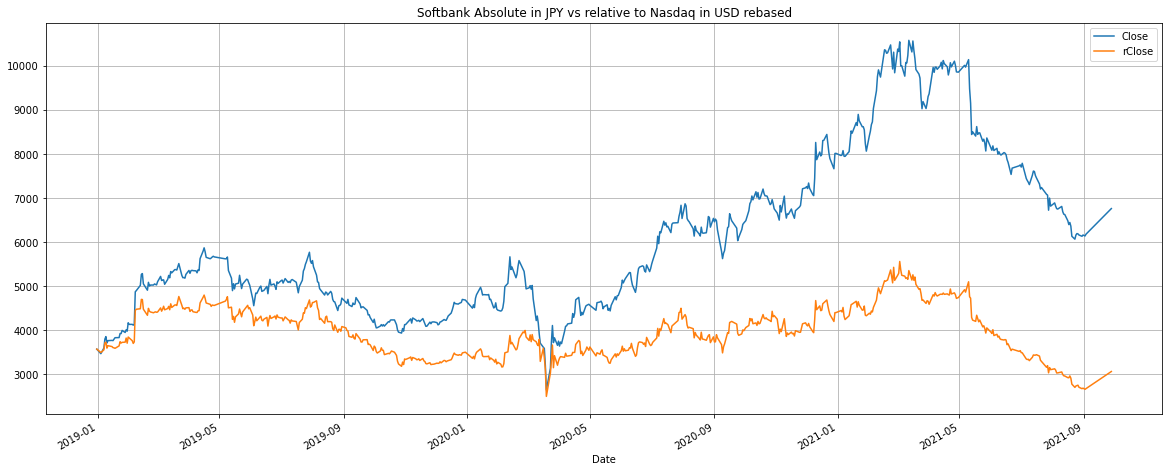

In [5]:
# Chapter 4: Long/Short Methodologies: Absolute and Relative

ticker = '9984.T' # Softbank
ohlc = ['Open','High','Low','Close']
_o,_h,_l,_c = [ohlc[h] for h in range(len(ohlc))]
start= '2018-12-30'
end = None
df =  round(yf.download(tickers= ticker,start= start, end = end, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None),2)
bm_df = pd.DataFrame()
bm_ticker = '^IXIC' #Nasdaq 
bm_col = 'nasdaq'
ccy_df = pd.DataFrame()
ccy_ticker = 'USDJPY=X'
ccy_col = 'JPY'
dgt = 5

bm_df[bm_col] =  yf.download(tickers= bm_ticker,start= start, end = end, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None)['Close']
ccy_df[ccy_col] =  yf.download(tickers= ccy_ticker,start= start, end = end, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None)['Close']

df = relative(df,_o,_h,_l,_c, bm_df, bm_col, ccy_df, ccy_col, dgt, start, end,rebase=True)

df[['Close','rClose']].plot(figsize=(20,8),grid=True,
            title= 'Softbank Absolute in JPY vs relative to Nasdaq in USD rebased' )



Same data, but the relative series is not rebased to the beginning of the series

<AxesSubplot:title={'center':'Softbank Absolute in JPY vs relative to Nasdaq in USD'}, xlabel='Date'>

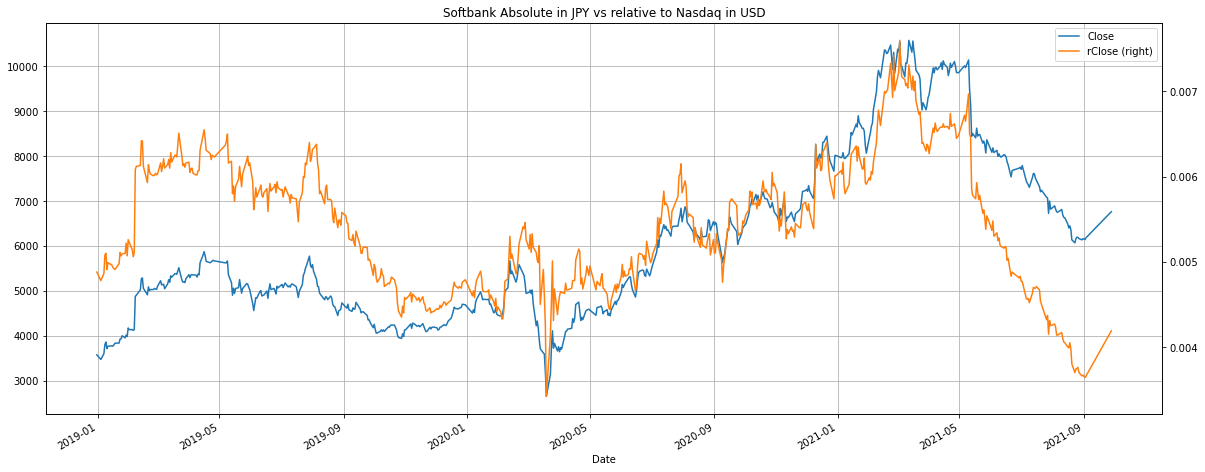

In [6]:
# Chapter 4: Long/Short Methodologies: Absolute and Relative


# Not included in the book

df2 = relative(df,_o,_h,_l,_c, bm_df, bm_col, ccy_df, ccy_col, dgt, start, end,rebase=False)
df2[['Close','rClose']].plot(figsize=(20,8),grid=True,secondary_y= 'rClose',
            title= 'Softbank Absolute in JPY vs relative to Nasdaq in USD' )

### Comparison of three stocks across 3 different sectors


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'GEMS Absolute Prices vs Relative Series'}, xlabel='Date'>

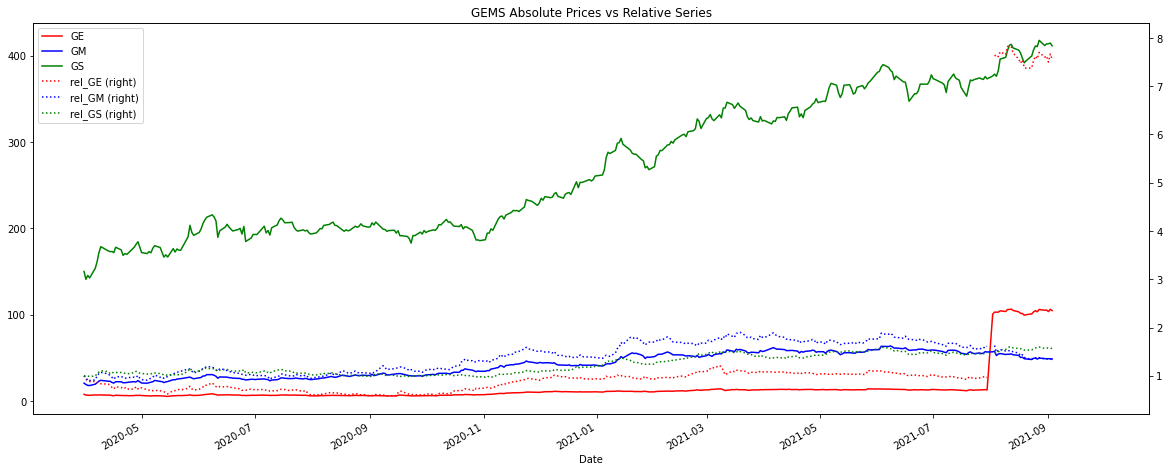

In [7]:
# Chapter 4: Long/Short Methodologies: Absolute and Relative

tickers_list = ['GE','GM','GS']

# Dataframes instantiation
gems = pd.DataFrame() 
start = '2020-03-31'
benchmark = yf.download(tickers= '^GSPC',start= start, end = None, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None)['Close']
failed = [] 
rel_ticker_list = []
for n,ticker in enumerate(tickers_list):
    try: #7 Download & process data
        gems[ticker] = yf.download(tickers= ticker,start= start, end = None, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None)['Close']
        gems['rel_'+ticker] = gems[ticker].div(benchmark * gems[ticker][0]) * benchmark[0]
        rel_ticker_list.append('rel_'+ticker)
    except:
        failed.append(ticker)
gems = gems[tickers_list+rel_ticker_list]
gems.plot(figsize= (20,8),secondary_y= rel_ticker_list,style=['r','b','g','r:','b:','g:'], 
          title= 'GEMS Absolute Prices vs Relative Series' )




### Wells Fargo 1 year before the scandal in absolute and relative

In [ ]:
# Chapter 4: Long/Short Methodologies: Absolute and Relative

ticker = 'WFC'
benchmark = '^GSPC'
tickers_list = [benchmark] + [ticker]

data = round(yf.download(tickers= tickers_list,start= '2015-09-07', end = None,
            interval = "1d",group_by = 'column',auto_adjust = True, 
            prepost = True, treads = True, proxy = None)['Close'],2)

data['r'+str(ticker)] = round(data[ticker].div(data[benchmark])*data[benchmark][0] ,2)
data[[ticker,'r'+str(ticker)]].plot(figsize=(20,8),grid=True,
title= str.upper(ticker)+ ' Absolute vs Relative series')